One the new feature added to the fitting procedure of Luci is a weighted Voronoï tessellation. We will describe here an example to showcase this method for your own data analysis.

You can download the example data using the following command:

In [1]:
# Imports
import sys
sys.path.insert(0, '/home/carterrhea/Documents/LUCI/')
from LuciBase import Luci
import matplotlib.pyplot as plt
import numpy as np
import LUCI.LuciPlotting as lplt
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import cm
from matplotlib.colors import LogNorm

2024-05-08 17:24:29.518372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 17:24:29.642740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/src/heasoft-6.31.1/x86_64-pc-linux-gnu-libc2.35/lib
2024-05-08 17:24:29.642764: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-08 17:24:31.104341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror:

The next step is to load/read the HDF5 data cube. To do this we invoke LUCI by initiating an instance of her along with the proper parameters. First we define the correct parameters:

In [2]:
# Initialize paths and set parameters
Luci_path = '/home/carterrhea/Documents/LUCI/'
cube_dir = '/export/home/carterrhea/M33'  # Path to data cube
cube_name = 'M33_SN3'  # don't add .hdf5 extension
object_name = 'M33'
filter_name = 'SN3'
redshift = -0.0006  # Redshift of M33
resolution = 5000

From there we will load the HDF5 cube following this command as usual.

In [3]:
cube = Luci(Luci_path, cube_dir+'/'+cube_name, cube_dir, object_name, redshift, resolution)

Reading in data...


100%|█████████████████████████████████████████████| 9/9 [00:34<00:00,  3.82s/it]


And extract a background region.

In [4]:
bkg_axis, bkg_sky = cube.extract_spectrum_region(Luci_path+'Examples/regions/bkg_M33.reg', mean=True)


100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 3596.32it/s]


Now we can call the wvt_fit_region function that will create the weighted Voronoï region and fit the bins to produce the maps we need.

In [15]:
cube.wvt_fit_region(
                1200, 1350,    # x bounds
                1700, 1950,    # y bounds
                ['NII6548', 'Halpha', 'NII6583'], 
                'sincgauss',
                [1,1,1],
                [1,1,1],
                stn_target = 20,
                bkg=bkg_sky,
                bayes_bool=False, 
                uncertainty_bool=False, 
                n_threads=20)

#----------------WVT Algorithm----------------#
#----------------Creating SNR Map--------------#


100%|█████████████████████████████████████████| 250/250 [03:37<00:00,  1.15it/s]


#----------------Algorithm Part 1----------------#
/home/carterrhea/Documents/LUCI/Examples
We have 37500 Pixels! :)
Running Nearest Neighbor Algorithm
Finished Nearest Neighbor Algorithm
Starting Bin Accretion Algorithm
Completed Bin Accretion Algorithm
There are a total of 16790 bins!
The first part of the algorithm took 00:08:37.
#----------------Algorithm Part 2----------------#
Beginning WVT
We are on step 1
Completed WVT in 1 step(s)!
There are a total of 16790 bins!
#----------------Algorithm Complete--------------#
#----------------Bin Mapping--------------#
#----------------Numpy Bin Mapping--------------#


100%|████████████████████████████████████| 16789/16789 [01:02<00:00, 268.26it/s]


#----------------WVT Fitting--------------#


100%|███████████████████████████████████| 16789/16789 [9:29:06<00:00,  2.03s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

As we can see there are many arguments in this function. Let's go through them one by one to make sure we use them correctly.

The first four arguments correspond to the position of the region we want to fit in the cube.

The fifth argument refers to the emission lines we want to fit.

'sincgauss' is the fitting function to be used.

The next two arguments describes the relational constraints between the lines. For example, if we are fitting three lines and we want the velocities of the second and third lines to be tied to one another, we would simply set vel_rel=[1,2,2]. If we wanted all the lines tied, then we would put [1,1,1]. The sigma_rel parameter functions in the exact same way except it affects the broadening (velocity dispersion) of the lines.

The stn_target parameter determines the signal to noise value that will act as a threshold to create the Voronoï tessels.

We then pass the background we want to subtract, as well as the Boolean parameters to determine whether or not to run Bayesian and uncertainty analysis.

The n_threads argument determines the number of threads used for the paralelization of the function, which accelerates the whole process.

### Outputs
The outputs will be in their usual locations (`Luci_outputs/...`) and will have `_wvt` in their names in addition to the stn_target value :D
For example the Halpha flux will be called `M33_Field7_wvt_100_Halpha_Flux`.

Let’s look at the flux map.

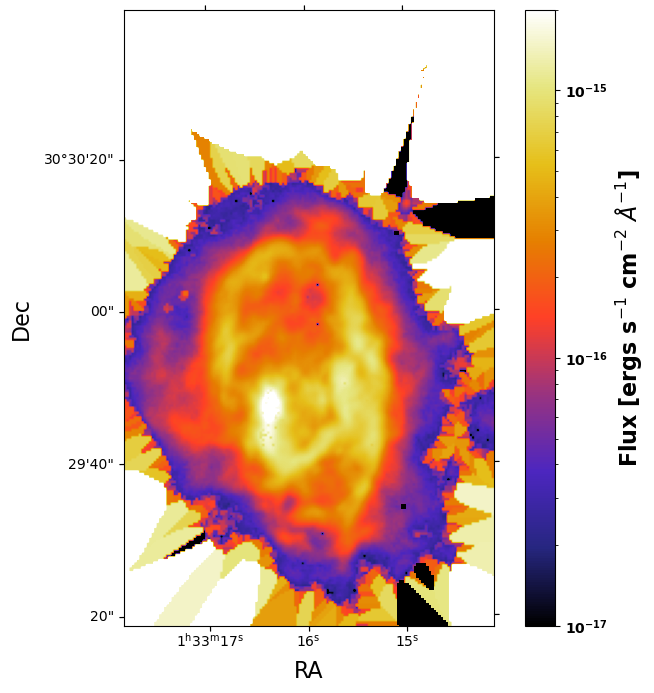

In [19]:
plt.rcdefaults()

flux_map = fits.open('/export/home/carterrhea/M33/Luci_outputs/Fluxes/M33_wvt_20_1_Halpha_Flux.fits')[0].data.T
header = fits.open('/export/home/carterrhea/M33/Luci_outputs/M33_deep.fits')[0].header
wcs = WCS(header)
cmap = cm.CMRmap
cmap.set_bad('black',1.)

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection=wcs)
plt.imshow(flux_map[1200: 1350, 1700: 1950].T, norm = LogNorm(vmin=1e-17, vmax=2e-15), origin='lower', cmap=cmap)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.xlabel(r'RA', fontsize=16)
plt.ylabel(r'Dec', fontsize=16)
cbar = plt.colorbar()
cbar.set_label(r'Flux [ergs s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]', fontsize=16)
plt.savefig('/home/carterrhea/Downloads/WVT_Example.png')

Since the SNR in around the nebula is low we have very large bins. Comparitively, the bins in the central regions are quite small.